In [164]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import warnings
import statistics
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error, accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix

## This projects goal is to analyze some of the descriptive statistics from public, synthetic medical claims files
#files were obtained from https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/DE_Syn_PUF

In [165]:
warnings.simplefilter(action = 'ignore')

##Initialize data
# read in data
inpatient = pd.read_csv('.../inpatient.csv')
outpatient = pd.read_csv('.../outpatient.csv')
bene = pd.read_csv('.../Beneficiary.csv')

#get a look into the data size
print('Inpatient claims data size:', inpatient.shape)
print('Outpatient claims data size:',outpatient.shape)
print('Beneficiary claims data size:', bene.shape)

Inpatient claims data size: (66773, 81)
Outpatient claims data size: (790790, 76)
Beneficiary claims data size: (116352, 32)


In [166]:
#display tables / get first glances
outpatient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790790 entries, 0 to 790789
Data columns (total 76 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   DESYNPUF_ID                     790790 non-null  object 
 1   CLM_ID                          790790 non-null  int64  
 2   SEGMENT                         790790 non-null  int64  
 3   CLM_FROM_DT                     779537 non-null  float64
 4   CLM_THRU_DT                     779537 non-null  float64
 5   PRVDR_NUM                       790790 non-null  object 
 6   CLM_PMT_AMT                     790790 non-null  float64
 7   NCH_PRMRY_PYR_CLM_PD_AMT        790790 non-null  float64
 8   AT_PHYSN_NPI                    773000 non-null  float64
 9   OP_PHYSN_NPI                    134433 non-null  float64
 10  OT_PHYSN_NPI                    257666 non-null  float64
 11  NCH_BENE_BLOOD_DDCTBL_LBLTY_AM  790790 non-null  float64
 12  ICD9_DGNS_CD_1  

In [167]:
bene.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116352 entries, 0 to 116351
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   DESYNPUF_ID               116352 non-null  object 
 1   BENE_BIRTH_DT             116352 non-null  int64  
 2   BENE_DEATH_DT             1814 non-null    float64
 3   BENE_SEX_IDENT_CD         116352 non-null  int64  
 4   BENE_RACE_CD              116352 non-null  int64  
 5   BENE_ESRD_IND             116352 non-null  object 
 6   SP_STATE_CODE             116352 non-null  int64  
 7   BENE_COUNTY_CD            116352 non-null  int64  
 8   BENE_HI_CVRAGE_TOT_MONS   116352 non-null  int64  
 9   BENE_SMI_CVRAGE_TOT_MONS  116352 non-null  int64  
 10  BENE_HMO_CVRAGE_TOT_MONS  116352 non-null  int64  
 11  PLAN_CVRG_MOS_NUM         116352 non-null  int64  
 12  SP_ALZHDMTA               116352 non-null  int64  
 13  SP_CHF                    116352 non-null  i

In [168]:
inpatient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66773 entries, 0 to 66772
Data columns (total 81 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   DESYNPUF_ID                     66773 non-null  object 
 1   CLM_ID                          66773 non-null  int64  
 2   SEGMENT                         66773 non-null  int64  
 3   CLM_FROM_DT                     66705 non-null  float64
 4   CLM_THRU_DT                     66705 non-null  float64
 5   PRVDR_NUM                       66773 non-null  object 
 6   CLM_PMT_AMT                     66773 non-null  float64
 7   NCH_PRMRY_PYR_CLM_PD_AMT        66773 non-null  float64
 8   AT_PHYSN_NPI                    66100 non-null  float64
 9   OP_PHYSN_NPI                    39058 non-null  float64
 10  OT_PHYSN_NPI                    7683 non-null   float64
 11  CLM_ADMSN_DT                    66773 non-null  int64  
 12  ADMTNG_ICD9_DGNS_CD             

In [169]:
##organize data as needed

#change beneficiary birthday to datetime
bene.BENE_BIRTH_DT =pd.to_datetime(bene.BENE_BIRTH_DT, format='%Y%m%d')

#add age in years as 'AGE_YEAR' to beneficiaries dataframe
now_time = pd.to_datetime('2010-01-01')
diff = now_time - bene.BENE_BIRTH_DT
diff_s = diff.dt.total_seconds()
age = divmod(diff_s, 31536000)

bene['AGE_YEARS'] = age[0]

#join outpatient claims and inpatient claims with beneficiaries data
inpatient = inpatient.join(bene.set_index('DESYNPUF_ID'), on='DESYNPUF_ID')
outpatient = outpatient.join(bene.set_index('DESYNPUF_ID'), on=('DESYNPUF_ID'))


#change inpatient and outpatient start and thru dates to datetime
inpatient[['CLM_THRU_DT', 'CLM_FROM_DT']] = inpatient[['CLM_THRU_DT', 'CLM_FROM_DT']].apply(
pd.to_datetime, format ='%Y%m%d')
outpatient[['CLM_THRU_DT', 'CLM_FROM_DT']] = outpatient[['CLM_THRU_DT', 'CLM_FROM_DT']].apply(
pd.to_datetime, format ='%Y%m%d')

#add year of claim to inpatient and outpatient data
inpatient['CLM_FROM_DT_YEAR'] = pd.DatetimeIndex(inpatient.CLM_FROM_DT).year
outpatient['CLM_FROM_DT_YEAR'] = pd.DatetimeIndex(outpatient.CLM_FROM_DT).year

inpatient['CLM_THRU_DT_YEAR'] = pd.DatetimeIndex(inpatient.CLM_THRU_DT).year
outpatient['CLM_THRU_DT_YEAR'] = pd.DatetimeIndex(outpatient.CLM_THRU_DT).year


#add column of count of number of chronic diseases per beneficiary 
count_disease =bene.iloc[:, 12:22]

for rowIndex, row in count_disease.iterrows():
    for columnIndex, value in row.items():
        if value == 2:
            count_disease.at[rowIndex,columnIndex] = 0

bene['TOTAL_CHRONIC_DISEASES'] = count_disease.sum(axis=1)


#remove rows with missing data in beneficiary birthday
inpatient = inpatient[inpatient.BENE_BIRTH_DT.notnull()]
outpatient = outpatient[outpatient.BENE_BIRTH_DT.notnull()]
inpatient = inpatient.drop_duplicates(subset='CLM_ID')
outpatient = outpatient.drop_duplicates(subset='CLM_ID')

#remove invalid data where age of beneficiaries is less than 65 
bene = bene[bene.AGE_YEARS > 65]

In [170]:
## create additional dataframes for later analysis

#inpatient / outpatient by year
inpatient_2008 = inpatient[
    inpatient.CLM_THRU_DT_YEAR == 2008.0].dropna(
        subset=['DESYNPUF_ID']).drop_duplicates(
            subset=['DESYNPUF_ID'])
inpatient_2009 = inpatient[
    inpatient.CLM_THRU_DT_YEAR == 2009.0].dropna(
        subset=['DESYNPUF_ID']).drop_duplicates(
            subset=['DESYNPUF_ID'])
inpatient_2010 = inpatient[
    inpatient.CLM_THRU_DT_YEAR == 2010.0].dropna(
        subset=['DESYNPUF_ID']).drop_duplicates(
            subset=['DESYNPUF_ID'])

outpatient_2008 = outpatient[
    outpatient.CLM_THRU_DT_YEAR == 2008.0].dropna(
        subset=['DESYNPUF_ID']).drop_duplicates(
            subset=['DESYNPUF_ID'])
outpatient_2009 = outpatient[
    outpatient.CLM_THRU_DT_YEAR == 2009.0].dropna(
        subset=['DESYNPUF_ID']).drop_duplicates(
            subset=['DESYNPUF_ID'])
outpatient_2010 = outpatient[
    outpatient.CLM_THRU_DT_YEAR == 2010.0].dropna(
        subset=['DESYNPUF_ID']).drop_duplicates(
            subset=['DESYNPUF_ID'])

In [171]:
##start analysis

#get distribution of number of claims per beneficiary
dist_claims_table = [['Claim Type', '25%', '50%', '75%', '90%'], 
['Outpatient Claims',
 outpatient.DESYNPUF_ID.value_counts().quantile(0.25), 
 outpatient.DESYNPUF_ID.value_counts().quantile(0.5),
 outpatient.DESYNPUF_ID.value_counts().quantile(0.75),
 outpatient.DESYNPUF_ID.value_counts().quantile(.9)],
 ['Inpatient Claims', 
 inpatient.DESYNPUF_ID.value_counts().quantile(0.25),
 inpatient.DESYNPUF_ID.value_counts().quantile(0.5),
 inpatient.DESYNPUF_ID.value_counts().quantile(0.75),
 inpatient.DESYNPUF_ID.value_counts().quantile(.9)
 ]]

#print results
print('Distribution of Number of Claims Per Beneficiary Over 3 Years')
print(tabulate(dist_claims_table, headers = 'firstrow', tablefmt = 'grid'))

Distribution of Number of Claims Per Beneficiary Over 3 Years
+-------------------+-------+-------+-------+-------+
| Claim Type        |   25% |   50% |   75% |   90% |
+===================+=======+=======+=======+=======+
| Outpatient Claims |     3 |     7 |    13 |    20 |
+-------------------+-------+-------+-------+-------+
| Inpatient Claims  |     1 |     1 |     2 |     3 |
+-------------------+-------+-------+-------+-------+


In [172]:
#get demographics of beneficiaries
sex_race_table = [
['', 'Outpatient', 'Inpatient'],

['Total', 
len(outpatient.DESYNPUF_ID.unique()), 
len(inpatient.DESYNPUF_ID.unique())
],

['Sex', '', ''],

['Male',
 str(
    round(
        len(
            outpatient[outpatient.BENE_SEX_IDENT_CD == 1])
            / 
            len(outpatient),3)
            * 100) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_SEX_IDENT_CD == 1])
            / 
            len(inpatient)), 3)
            * 100) + '%'
],
['Female', 
str(
    round(
        (len(
            outpatient[outpatient.BENE_SEX_IDENT_CD == 2])
            / 
            len(outpatient)) * 100,1)) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_SEX_IDENT_CD == 2])
            / 
            len(inpatient))*100, 1)) + '%'

], 

['Race/Ethnicity', '', ''],

['White', 
str(
    round(
        (len(
            outpatient[outpatient.BENE_RACE_CD == 1])
            / 
            len(outpatient)) * 100,1)) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_RACE_CD == 1])
            / 
            len(inpatient))*100, 1)) + '%'
],

['Black', 
str(
    round(
        (len(
            outpatient[outpatient.BENE_RACE_CD == 2])
            / 
            len(outpatient)) * 100,1)) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_RACE_CD == 2])
            / 
            len(inpatient))*100, 1)) + '%'
],

['Hispanic',
str(
    round(
        (len(
            outpatient[outpatient.BENE_RACE_CD == 3])
            / 
            len(outpatient)) * 100,1)) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_RACE_CD == 3])
            / 
            len(inpatient))*100, 1)) + '%'
],

['Other',
str(
    round(
        (len(
            outpatient[outpatient.BENE_RACE_CD == 5])
            / 
            len(outpatient)) * 100,1)) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_RACE_CD == 5])
            / 
            len(inpatient))*100, 1)) + '%'
]
]


print('Sex and Race of Population')
print(tabulate(sex_race_table,headers = 'firstrow', tablefmt = 'grid'))


Sex and Race of Population
+----------------+--------------+-------------+
|                | Outpatient   | Inpatient   |
+================+==============+=============+
| Total          | 85272        | 37780       |
+----------------+--------------+-------------+
| Sex            |              |             |
+----------------+--------------+-------------+
| Male           | 42.3%        | 43.4%       |
+----------------+--------------+-------------+
| Female         | 57.7%        | 56.6%       |
+----------------+--------------+-------------+
| Race/Ethnicity |              |             |
+----------------+--------------+-------------+
| White          | 84.6%        | 84.4%       |
+----------------+--------------+-------------+
| Black          | 9.9%         | 10.5%       |
+----------------+--------------+-------------+
| Hispanic       | 3.5%         | 3.1%        |
+----------------+--------------+-------------+
| Other          | 2.0%         | 1.9%        |
+------------

In [173]:
#comparison of birth ranges of population of beneficiaries

birth_table = [
['Year of Birth', 'Population of Outpatient Claims','Population of Inpatient Claims'],

['-1924',
str(
    round(
        (len(
            outpatient[outpatient.BENE_BIRTH_DT < '1924-01-01'])
            / 
            len(outpatient)) * 100,1)) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_BIRTH_DT < '1924-01-01'])
            / 
            len(inpatient))*100, 1)) + '%'
],

['1924-1928',
str(
    round(
        (len(
            outpatient[outpatient.BENE_BIRTH_DT.between('1924-01-01', '1928-12-31', inclusive = True)])
            / 
            len(outpatient)) * 100,1)) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_BIRTH_DT.between('1924-01-01', '1928-12-31', inclusive = True)])
            / 
            len(inpatient))*100, 1)) + '%'
],

['1929-1933',
str(
    round(
        (len(
            outpatient[outpatient.BENE_BIRTH_DT.between('1929-01-01', '1933-12-31', inclusive = True)])
            / 
            len(outpatient)) * 100,1)) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_BIRTH_DT.between('1929-01-01', '1933-12-31', inclusive = True)])
            / 
            len(inpatient))*100, 1)) + '%'
],

['1934-1938',
str(
    round(
        (len(
            outpatient[outpatient.BENE_BIRTH_DT.between('1934-01-01', '1938-12-31', inclusive = True)])
            / 
            len(outpatient)) * 100,1)) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_BIRTH_DT.between('1934-01-01', '1938-12-31', inclusive = True)])
            / 
            len(inpatient))*100, 1)) + '%'
],

['1939-1943',
str(
    round(
        (len(
            outpatient[outpatient.BENE_BIRTH_DT.between('1939-01-01', '1943-12-31', inclusive = True)])
            / 
            len(outpatient)) * 100,1)) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_BIRTH_DT.between('1939-01-01', '1943-12-31', inclusive = True)])
            / 
            len(inpatient))*100, 1)) + '%'
],

['1943-',
str(
    round(
        (len(
            outpatient[outpatient.BENE_BIRTH_DT > '1944-01-01'])
            / 
            len(outpatient)) * 100,1)) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_BIRTH_DT > '1944-01-01'])
            / 
            len(inpatient))*100, 1)) + '%'
],

['Mean Age',
round(statistics.mean(outpatient.AGE_YEARS),1),
round(statistics.mean(inpatient.AGE_YEARS),1)
]

]

#print results
print('Year of Birth of Beneficiary Population')
print(tabulate(birth_table, headers = 'firstrow', tablefmt = 'grid' ))

Year of Birth of Beneficiary Population
+-----------------+-----------------------------------+----------------------------------+
| Year of Birth   | Population of Outpatient Claims   | Population of Inpatient Claims   |
+=================+===================================+==================================+
| -1924           | 14.8%                             | 17.4%                            |
+-----------------+-----------------------------------+----------------------------------+
| 1924-1928       | 14.0%                             | 14.9%                            |
+-----------------+-----------------------------------+----------------------------------+
| 1929-1933       | 16.4%                             | 16.4%                            |
+-----------------+-----------------------------------+----------------------------------+
| 1934-1938       | 18.2%                             | 16.8%                            |
+-----------------+-------------------------------

In [174]:
#analysis of amount paid by Medicare / Beneficiary / 3rd Party,
#compared by inpatient vs outpatient treatment

amt_paid_table = [
['Reimbursement Source','Inpatient','Outpatient', 'Difference'],

['Medicare Paid',
'$' + str(
        round(statistics.mean(bene.MEDREIMB_IP), 2)),
'$' + str(
        round(statistics.mean(bene.MEDREIMB_OP),2)),
'$' + str(
        round(
            statistics.mean(bene.MEDREIMB_IP) - 
            statistics.mean(bene.MEDREIMB_OP), 2))
],

['Beneficiary Paid', 
'$' + str(
        round(statistics.mean(bene.BENRES_IP),2)),
'$' + str(
        round(statistics.mean(bene.BENRES_OP),2)),
'$' + str(
        round(
            statistics.mean(bene.BENRES_IP) - 
            statistics.mean(bene.BENRES_OP), 2))
],

['3rd Party Paid',
'$' + str(
        round(statistics.mean(bene.PPPYMT_IP), 2)),
'$' + str(
        round(statistics.mean(bene.PPPYMT_OP),2)),
'$' + str(
        round(
            statistics.mean(bene.PPPYMT_IP) - 
            statistics.mean(bene.PPPYMT_OP), 2))
],

['Total', 
'$' + str(
        round(
            statistics.mean(bene.PPPYMT_IP) + 
            statistics.mean(bene.MEDREIMB_IP) + 
            statistics.mean(bene.BENRES_IP), 
            2)),
'$' + str(
        round( 
            statistics.mean(bene.PPPYMT_OP) + 
            statistics.mean(bene.MEDREIMB_OP) + 
            statistics.mean(bene.BENRES_OP),
            2)),
'$' + str(
        round(
            (statistics.mean(bene.PPPYMT_IP) + 
            statistics.mean(bene.MEDREIMB_IP) + 
            statistics.mean(bene.BENRES_IP)) -
            (statistics.mean(bene.PPPYMT_OP) + 
            statistics.mean(bene.MEDREIMB_OP) + 
            statistics.mean(bene.BENRES_OP)),
            2))
]


]

print(tabulate(amt_paid_table, headers = 'firstrow', tablefmt = 'grid'))



+------------------------+-------------+--------------+--------------+
| Reimbursement Source   | Inpatient   | Outpatient   | Difference   |
+========================+=============+==============+==============+
| Medicare Paid          | $2201.23    | $611.13      | $1590.1      |
+------------------------+-------------+--------------+--------------+
| Beneficiary Paid       | $245.79     | $194.33      | $51.46       |
+------------------------+-------------+--------------+--------------+
| 3rd Party Paid         | $96.4       | $25.38       | $71.02       |
+------------------------+-------------+--------------+--------------+
| Total                  | $2543.41    | $830.84      | $1712.57     |
+------------------------+-------------+--------------+--------------+


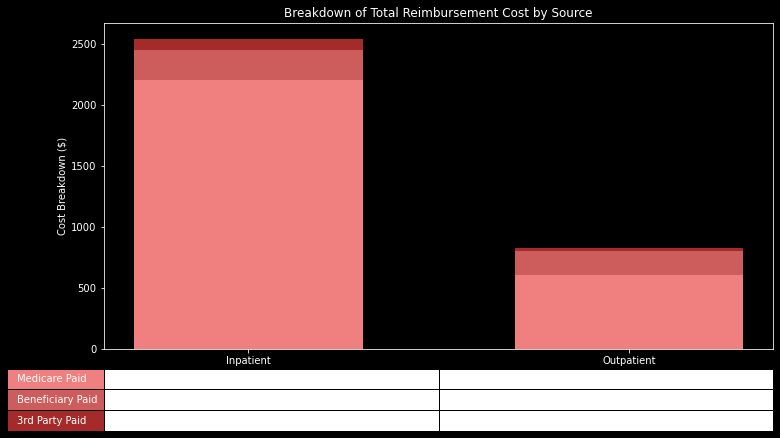

In [175]:
## create barplot of cost breakdown

inpatient_costs = pd.DataFrame(
    [[round(statistics.mean(bene.MEDREIMB_IP),2), round(statistics.mean(bene.BENRES_IP),2), round(statistics.mean(bene.PPPYMT_IP), 2)], 
    [round(statistics.mean(bene.MEDREIMB_OP),2), round(statistics.mean(bene.BENRES_OP),2), round(statistics.mean(bene.PPPYMT_OP), 2)]],
    columns = ['Medicare Paid', 'Beneficiary Paid', '3rd Party Paid'],
    index = ['Inpatient', 'Outpatient'])

barWidth = 0.6
colors = plt.cm.BuPu(np.linspace(0, 0.5, 3))


fig, ax = plt.subplots(figsize = (12,6))


p1 = ax.bar(inpatient_costs.index, inpatient_costs['Medicare Paid'], width = barWidth, color = 'lightcoral')

p2 = ax.bar(inpatient_costs.index, inpatient_costs['Beneficiary Paid'],
width = barWidth, bottom = inpatient_costs['Medicare Paid'], color = 'indianred')

p3 = ax.bar(inpatient_costs.index, inpatient_costs['3rd Party Paid'], width = barWidth,
bottom = (inpatient_costs['Beneficiary Paid'] + inpatient_costs['Medicare Paid']), 
color = 'brown')

ax.set_ylabel('Cost Breakdown ($)')
plt.title('Breakdown of Total Reimbursement Cost by Source')

the_table = ax.table(cellText = inpatient_costs.T.values,
                     rowLabels = inpatient_costs.columns,
                     rowColours= ['lightcoral', 'indianred', 'brown'],
                     cellLoc = 'center',
                     bbox=([0,-0.25, 1,0.19])
                     )






In [176]:
#Look into the presence of chronic illnesses in beneficiaries and mean age of condition

chronic_cond_table = [
['Disease', 'Prevalence in Beneficiaries (%)', 'Mean Age with Condition'],

['Ischemic Heart Disease',
round(
    (len(bene[bene.SP_ISCHMCHT == 1]) / 
    len(bene)) * 100, 2),
round(
    statistics.mean(
        bene.AGE_YEARS.where(bene.SP_ISCHMCHT == 1).dropna()), 2)
],

['Diabetes',
round(
    (len(bene[bene.SP_DIABETES == 1]) / 
    len(bene)) * 100, 2),
round(
    statistics.mean(
        bene.AGE_YEARS.where(bene.SP_DIABETES == 1).dropna()), 2)
],

['Heart failure',
round(
    (len(bene[bene.SP_CHF == 1]) / 
    len(bene)) * 100, 2),
round(
    statistics.mean(
        bene.AGE_YEARS.where(bene.SP_CHF == 1).dropna()), 2)
],

['Depression',
round(
    (len(bene[bene.SP_DEPRESSN == 1]) / 
    len(bene)) * 100, 2),
round(
    statistics.mean(
        bene.AGE_YEARS.where(bene.SP_DEPRESSN == 1).dropna()), 2)
],

["Alzheimer's",
round(
    (len(bene[bene.SP_ALZHDMTA == 1]) /
    len(bene)) * 100, 2),
round(
    statistics.mean(
        bene.AGE_YEARS.where(bene.SP_ALZHDMTA == 1).dropna()), 2)
],

['Osteoporosis',
round(
    (len(bene[bene.SP_OSTEOPRS == 1]) / 
    len(bene)) * 100, 2),
round(
    statistics.mean(
        bene.AGE_YEARS.where(bene.SP_OSTEOPRS == 1).dropna()), 2)
],

['Kidney Disease',
round(
    (len(bene[bene.SP_CHRNKIDN == 1]) / 
    len(bene)) * 100, 2),
round(
    statistics.mean(
        bene.AGE_YEARS.where(bene.SP_CHRNKIDN == 1).dropna()), 2)
],

['Rheumatoid Arthritis / Osteoarthritis',
round(
    (len(bene[bene.SP_RA_OA == 1]) / 
    len(bene)) * 100, 2),
round(
    statistics.mean(
        bene.AGE_YEARS.where(bene.SP_RA_OA == 1).dropna()), 2)
],

['Chronic Obstructive Pulmonary Disease',
round(
    (len(bene[bene.SP_COPD == 1]) / 
    len(bene)) * 100, 2),
round(
    statistics.mean(
        bene.AGE_YEARS.where(bene.SP_COPD == 1).dropna()), 2)
],

['Cancer',
round(
    (len(bene[bene.SP_CNCR == 1]) / 
    len(bene)) * 100, 2),
round(
    statistics.mean(
        bene.AGE_YEARS.where(bene.SP_CNCR == 1).dropna()), 2)
],

['Stroke',
round(
    (len(bene[bene.SP_STRKETIA == 1]) / 
    len(bene)) * 100, 2),
round(
    statistics.mean(
        bene.AGE_YEARS.where(bene.SP_STRKETIA == 1).dropna()), 2)
]

]

print(tabulate(chronic_cond_table, headers = 'firstrow', tablefmt = 'grid'))


+---------------------------------------+-----------------------------------+---------------------------+
| Disease                               |   Prevalence in Beneficiaries (%) |   Mean Age with Condition |
+=======================================+===================================+===========================+
| Ischemic Heart Disease                |                             42.41 |                     77.87 |
+---------------------------------------+-----------------------------------+---------------------------+
| Diabetes                              |                             37.97 |                     77.97 |
+---------------------------------------+-----------------------------------+---------------------------+
| Heart failure                         |                             28.59 |                     78.3  |
+---------------------------------------+-----------------------------------+---------------------------+
| Depression                            |     

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Ischemic Heart Disease'),
  Text(1, 0, 'Diabetes'),
  Text(2, 0, 'Heart Failure'),
  Text(3, 0, 'Depression'),
  Text(4, 0, "Alzheimer's"),
  Text(5, 0, 'Osteoporosis'),
  Text(6, 0, 'Kidney Disease'),
  Text(7, 0, 'Arthritis'),
  Text(8, 0, 'COPD'),
  Text(9, 0, 'Cancer'),
  Text(10, 0, 'Stroke')])

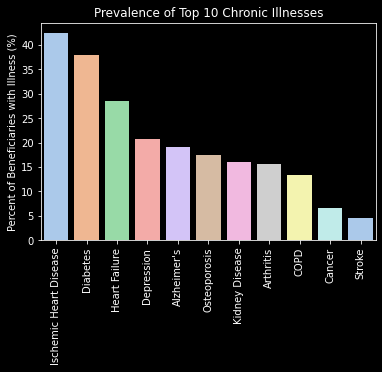

In [177]:
#create bar plot to describe top 10 chronic illness percentages in beneficiaries

diseases = ['Ischemic Heart Disease', 'Diabetes', 
'Heart Failure', 'Depression', "Alzheimer's", 
'Osteoporosis', 'Kidney Disease', 'Arthritis', 
'COPD', 'Cancer', 'Stroke']

prevalence = [
    round(
    (len(bene[bene.SP_ISCHMCHT == 1]) / 
    len(bene)) * 100, 2),

    round(
    (len(bene[bene.SP_DIABETES == 1]) / 
    len(bene)) * 100, 2),

    round(
    (len(bene[bene.SP_CHF == 1]) / 
    len(bene)) * 100, 2),

    round(
    (len(bene[bene.SP_DEPRESSN == 1]) / 
    len(bene)) * 100, 2),

    round(
    (len(bene[bene.SP_ALZHDMTA == 1]) /
    len(bene)) * 100, 2),

    round(
    (len(bene[bene.SP_OSTEOPRS == 1]) / 
    len(bene)) * 100, 2),

    round(
    (len(bene[bene.SP_CHRNKIDN == 1]) / 
    len(bene)) * 100, 2),

    round(
    (len(bene[bene.SP_RA_OA == 1]) / 
    len(bene)) * 100, 2),

    round(
    (len(bene[bene.SP_COPD == 1]) / 
    len(bene)) * 100, 2),

    round(
    (len(bene[bene.SP_CNCR == 1]) / 
    len(bene)) * 100, 2),

    round(
    (len(bene[bene.SP_STRKETIA == 1]) / 
    len(bene)) * 100, 2)
]
plt.style.use("dark_background")

sns.barplot(
    x = diseases,
    y = prevalence,
    palette = 'pastel'
)
plt.title('Prevalence of Top 10 Chronic Illnesses')
plt.ylabel("Percent of Beneficiaries with Illness (%)")
plt.xticks(rotation = 90)


Text(0, 0.5, 'Number of Chronic Illnesses')

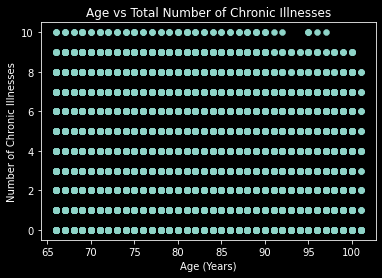

In [178]:
#Investigate whether there is a correlation between age and the number of chronic illnesses per beneficiaries


#plot scatter plot of age vs number of chronic illnesses to observe relationship
fig, ax = plt.subplots()
ax.scatter(bene.AGE_YEARS, bene.TOTAL_CHRONIC_DISEASES, linewidths = 0.5)
plt.title('Age vs Total Number of Chronic Illnesses')
plt.xlabel('Age (Years)')
plt.ylabel('Number of Chronic Illnesses')




Average Age of Beneficiaries with Alzheimer's Disease: 78.46618162220426
Average Age of Beneficiaries without Alzheimer's Disease: 75.99920445505171
Pearson correlation coefficient between Age and Alzheimer's Disease: -0.09905236909587523


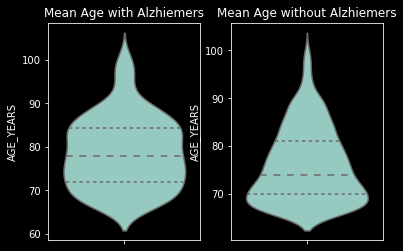

In [179]:

#investigate data of alzheimer's disease, 
#find out why there is no relationship between age and illness
fig, ax2 = plt.subplots()
ax2.scatter(bene.AGE_YEARS, bene.SP_ALZHDMTA, linewidths = 0.05)
plt.title("Age vs Presence of Alzheimer's Disease")
plt.xlabel('Age (Years)')
plt.ylabel("Presence of Alzheimer's Disease")

#plot age distributions between beneficiaries with and without alzhiemers

has_alz = bene.where(bene.SP_ALZHDMTA == 1).dropna()
no_alz = bene.where(bene.SP_ALZHDMTA == 2.0).dropna()

plt.style.use("dark_background")
plt.subplot(1,2,1)
sns.violinplot(y = has_alz.AGE_YEARS, orient = 'v', inner = 'quartile')
plt.title('Mean Age with Alzhiemers')
plt.subplot(1,2,2)
sns.violinplot(y = no_alz.AGE_YEARS, orient = 'v', inner = 'quartile')
plt.title('Mean Age without Alzhiemers')


print("\nAverage Age of Beneficiaries with Alzheimer's Disease:", statistics.mean(bene.AGE_YEARS.where(bene.SP_ALZHDMTA == 1).dropna()))
print("Average Age of Beneficiaries without Alzheimer's Disease:", statistics.mean(no_alz.AGE_YEARS))
print("Pearson correlation coefficient between Age and Alzheimer's Disease:", 
bene.corr(method = 'pearson')['SP_ALZHDMTA']['AGE_YEARS'])
